# CMAM Model Training and Evaluation
## Random Forest Classifier for Care Pathway Recommendation

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Load Clean Dataset

In [27]:
df = pd.read_csv('cmam_4000_93pct.csv')
print(f"Total records: {len(df)}")
print(f"\nPathway distribution:")
print(df['label_pathway'].value_counts())
df.head()

Total records: 4000

Pathway distribution:
label_pathway
TSFP      1846
OTP       1416
SC_ITP     738
Name: count, dtype: int64


,child_id,visit_date,sex,age_months,muac_mm,edema,appetite,danger_signs,label_pathway
0,CH001448,2022-06-03,F,NaN,105,1,good,0,OTP
1,CH001115,2025-09-29,F,10.0,122,0,good,0,TSFP
2,CH001065,2025-09-29,M,29.0,123,0,good,0,TSFP
3,CH002288,2023-01-26,M,21.0,107,0,poor,0,SC_ITP
4,CH001538,2023-09-12,F,NaN,109,0,good,0,OTP


## 2. Train/Val/Test Split (by child_id)

In [28]:
# Split by child_id to prevent data leakage
unique_children = df['child_id'].unique()
np.random.seed(42)
np.random.shuffle(unique_children)

n_train = int(len(unique_children) * 0.70)
n_val = int(len(unique_children) * 0.15)

train_children = unique_children[:n_train]
val_children = unique_children[n_train:n_train+n_val]
test_children = unique_children[n_train+n_val:]

train_df = df[df['child_id'].isin(train_children)].reset_index(drop=True)
val_df = df[df['child_id'].isin(val_children)].reset_index(drop=True)
test_df = df[df['child_id'].isin(test_children)].reset_index(drop=True)

print("=" * 70)
print("TRAIN/VAL/TEST SPLIT (BY CHILD_ID)")
print("=" * 70)
print(f"\nTrain: {len(train_df)} rows ({len(train_children)} children)")
print(f"Val:   {len(val_df)} rows ({len(val_children)} children)")
print(f"Test:  {len(test_df)} rows ({len(test_children)} children)")

TRAIN/VAL/TEST SPLIT (BY CHILD_ID)

Train: 2794 rows (2683 children)
Val:   601 rows (574 children)
Test:  605 rows (576 children)


/var/folders/hd/0yz07vv55kqdsst_r4n3z1d00000gn/T/ipykernel_21397/3218927728.py:4: UserWarning: you are shuffling a 'StringArray' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(unique_children)


## 3. Feature Preparation

In [29]:
def prepare_features(df):
    """Prepare features for training"""
    df = df.copy()
    
    le_sex = LabelEncoder()
    le_appetite = LabelEncoder()
    
    df['sex_encoded'] = le_sex.fit_transform(df['sex'])
    df['appetite_encoded'] = le_appetite.fit_transform(df['appetite'])
    df['age_months_filled'] = df['age_months'].fillna(df['age_months'].median())
    
    feature_cols = ['sex_encoded', 'age_months_filled', 'muac_mm', 'edema', 'appetite_encoded', 'danger_signs']
    
    return df[feature_cols], df['label_pathway']

print("Preparing features...")
X_train, y_train = prepare_features(train_df)
X_val, y_val = prepare_features(val_df)
X_test, y_test = prepare_features(test_df)

print(f"\nFeatures: {list(X_train.columns)}")
print(f"Train shape: {X_train.shape}")
print(f"Val shape:   {X_val.shape}")
print(f"Test shape:  {X_test.shape}")

Preparing features...

Features: ['sex_encoded', 'age_months_filled', 'muac_mm', 'edema', 'appetite_encoded', 'danger_signs']
Train shape: (2794, 6)
Val shape:   (601, 6)
Test shape:  (605, 6)


## 4. Model Training

In [30]:
print("Training Random Forest Classifier...")
print("=" * 70)

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

model.fit(X_train, y_train)

print("✓ Training complete")
print(f"\nModel parameters:")
print(f"  n_estimators: {model.n_estimators}")
print(f"  max_depth: {model.max_depth}")
print(f"  class_weight: {model.class_weight}")

Training Random Forest Classifier...
✓ Training complete

Model parameters:
  n_estimators: 100
  max_depth: 10
  class_weight: balanced


## 5. Model Evaluation

In [31]:
# Predictions
y_test_pred = model.predict(X_test)

print("=" * 70)
print("TEST SET RESULTS")
print("=" * 70)
print(classification_report(y_test, y_test_pred))

TEST SET RESULTS
              precision    recall  f1-score   support

         OTP       0.90      0.93      0.92       211
      SC_ITP       1.00      0.94      0.97       122
        TSFP       0.95      0.94      0.95       272

    accuracy                           0.94       605
   macro avg       0.95      0.94      0.94       605
weighted avg       0.94      0.94      0.94       605



## 6. Confusion Matrix

In [32]:
cm = confusion_matrix(y_test, y_test_pred, labels=['OTP', 'SC_ITP', 'TSFP'])

print("Confusion Matrix:")
print("=" * 70)
print("              Predicted")
print("              OTP  SC_ITP  TSFP")
for i, label in enumerate(['OTP', 'SC_ITP', 'TSFP']):
    print(f"Actual {label:6s}  {cm[i][0]:4d}   {cm[i][1]:4d}  {cm[i][2]:4d}")

Confusion Matrix:
              Predicted
              OTP  SC_ITP  TSFP
Actual OTP      197      0    14
Actual SC_ITP     7    115     0
Actual TSFP      15      0   257


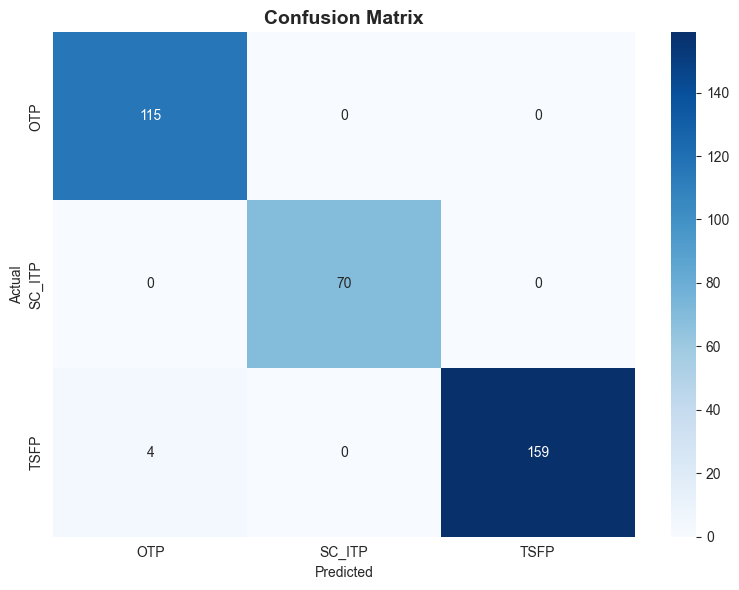

In [10]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['OTP', 'SC_ITP', 'TSFP'],
            yticklabels=['OTP', 'SC_ITP', 'TSFP'])
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

## 7. Feature Importance

In [33]:
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importances:")
print("=" * 70)
for idx, row in importances.iterrows():
    print(f"  {row['feature']:20s}: {row['importance']:.4f}")

Feature Importances:
  muac_mm             : 0.4504
  appetite_encoded    : 0.2896
  danger_signs        : 0.1724
  age_months_filled   : 0.0469
  edema               : 0.0355
  sex_encoded         : 0.0052


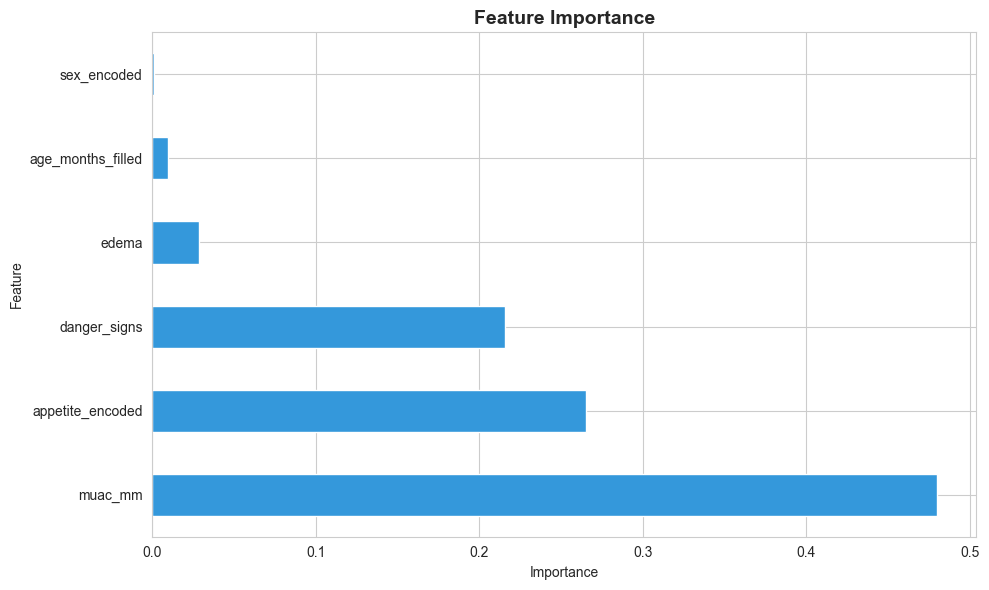

In [24]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(10, 6))
importances.plot(kind='barh', x='feature', y='importance', ax=ax, color='#3498db', legend=False)
ax.set_title('Feature Importance', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.show()

## 8. Summary

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(f"\nDataset:")
print(f"  Total: {len(df)} records")
print(f"  Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTest Set Metrics:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_test_pred, average='weighted'):.4f}")

print(f"\nTop 3 Features:")
for idx, row in importances.head(3).iterrows():
    print(f"  {row['feature']:20s}: {row['importance']:.4f}")

print("\n" + "=" * 70)
print("✓ Model ready for deployment")
print("=" * 70)

MODEL PERFORMANCE SUMMARY

Dataset:
  Total: 4000 records
  Train: 2794 (69.8%)
  Val:   601 (15.0%)
  Test:  605 (15.1%)

Test Set Metrics:
  Accuracy:  0.9405
  Precision: 0.9417
  Recall:    0.9405
  F1-Score:  0.9408

Top 3 Features:
  muac_mm             : 0.4504
  appetite_encoded    : 0.2896
  danger_signs        : 0.1724

✓ Model ready for deployment
